## Setup

In [1]:
!pip install pyvene


import pyvene as pv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 41.0 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0


In [2]:
import pandas as pd
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    get_linear_schedule_with_warmup,
)
import torch
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

%config InlineBackend.figure_formats = ['svg']
from plotnine import (
    ggplot,
    geom_tile,
    aes,
    facet_wrap,
    theme,
    element_text,
    geom_bar,
    geom_hline,
    scale_y_log10,
    geom_line,
    geom_point,
    geom_text,
    ggtitle, xlab, ylab,
    ggsave
)
from plotnine.scales import scale_y_reverse, scale_fill_cmap
from tqdm import tqdm
from collections import namedtuple

## Load model and data

In [3]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = "EleutherAI/pythia-70m" # "EleutherAI/pythia-6.9B"
tokenizer = AutoTokenizer.from_pretrained(model)
tokenizer.pad_token = tokenizer.eos_token
gpt = AutoModelForCausalLM.from_pretrained(
    model,
    revision="main",
    torch_dtype=torch.bfloat16 if model == "EleutherAI/pythia-6.9b" else torch.float32,
).to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


tokenizer_config.json:   0%|          | 0.00/396 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/567 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/166M [00:00<?, ?B/s]

The `GPTNeoXSdpaAttention` class is deprecated in favor of simply modifying the `config._attn_implementation`attribute of the `GPTNeoXAttention` class! It will be removed in v4.48


In [4]:
from datasets import load_dataset

ds = load_dataset("tasksource/babi_nli", "basic-induction")

README.md:   0%|          | 0.00/15.3k [00:00<?, ?B/s]

(…)-00000-of-00001-e4f63ffe92e2fa74.parquet:   0%|          | 0.00/38.7k [00:00<?, ?B/s]

(…)-00000-of-00001-b4ca97bd31543496.parquet:   0%|          | 0.00/22.9k [00:00<?, ?B/s]

(…)-00000-of-00001-1d9d7076b3cb6b66.parquet:   0%|          | 0.00/23.5k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/500 [00:00<?, ? examples/s]

We have a list of 100 names for each gender, and we'll filter for names that are one token in length. We'll further filter for examples the model agrees with our labels for, since some of these names might be ambiguous or the model might not have the expected behaviour. This ensures that baseline IIA is 0.

In [5]:
def get_input_and_label(sample):
    full_sample = sample["hypothesis"] + " " + sample["premise"]
    elements = full_sample.split(" ")
    input_ = " ".join(elements[:-1]) + " "
    label = elements[-1].rstrip(".!? \n")
    return input_, label

In [6]:
COLOR_LABELS = ['gray', 'green', 'white', 'yellow']

def filter_dataset(ds):
    filtered_ds = []
    for sample in ds:
        if sample["label"] == 0:
            input_, label = get_input_and_label(sample)
            if label in COLOR_LABELS:
                filtered_ds.append({"sample": input_, "label": label})
    return filtered_ds

In [7]:
filtered_dataset = filter_dataset(ds["train"])

In [8]:
unique_labels = set([sample["label"] for sample in filtered_dataset])

In [9]:
unique_labels

{'gray', 'green', 'white', 'yellow'}

In [10]:
for label in unique_labels:
    tokenized = tokenizer.encode(label)
    print(tokenized)

[28659]
[27250]
[11300]
[11707]


In [11]:
Example = namedtuple("Example", ["base", "src", "base_label", "src_label"])

def sample_example(tokenizer):
    base_sample = random.choice(filtered_dataset)
    src_samples = [sample for sample in filtered_dataset if sample["label"] != base_sample["label"]]

    src_sample = random.choice(src_samples)

    base = tokenizer(base_sample["sample"], return_tensors="pt")
    src = tokenizer(src_sample["sample"], return_tensors="pt")
    base_label = tokenizer.encode(base_sample["label"])[0]
    src_label = tokenizer.encode(src_sample["label"])[0]
    return Example(base, src, base_label, src_label)

In [12]:
def generate_n_doable_examples(n, model, tokenizer):
    examples = []
    iterator = tqdm(range(n))
    while len(examples) < n:
        ex = sample_example(tokenizer)
        for k, v in ex.base.items():
            if v is not None and isinstance(v, torch.Tensor):
                ex.base[k] = v.to(model.device)
        for k, v in ex.src.items():
            if v is not None and isinstance(v, torch.Tensor):
                ex.src[k] = v.to(model.device)
        logits_base = model(**ex.base).logits[0, -1]
        logits_src = model(**ex.src).logits[0, -1]
        if (
            logits_base[ex.base_label] > logits_base[ex.src_label]
            and logits_src[ex.src_label] > logits_src[ex.base_label]
        ):
            examples.append(ex)
            iterator.update(1)
    return examples

In [13]:
# make dataset
total_steps = 300
trainset = generate_n_doable_examples(total_steps, gpt, tokenizer)
evalset = generate_n_doable_examples(50, gpt, tokenizer)



print(f"Liczba przykładów w zbiorze treningowym: {len(trainset)}")
print(f"Liczba przykładów w zbiorze walidacyjnym: {len(evalset)}")
print("Przykład z trainset:", trainset[0])
print("Przykład z evalset:", evalset[0])

100%|██████████| 50/50 [00:08<00:00,  5.60it/s]

Liczba przykładów w zbiorze treningowym: 300
Liczba przykładów w zbiorze walidacyjnym: 50
Przykład z trainset: Example(base={'input_ids': tensor([[35119,   310, 11978,    15, 32817,   310,   247, 27405,    15, 13916,
           310,   247, 27405,    15, 44402,   310,   247,  1863,   266,    15,
         13916,   310, 11978,    15, 44402,   310,  4759,    15, 10246, 10984,
           310,   247, 40096,    15, 10246, 10984,   310,  8862,    15, 14468,
           310,   247,  1863,   266,    15, 32817,   310,   209]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0')}, src={'input_ids': tensor([[31080, 10984,   310,  3168,    15, 14468,   310,   247, 13882,  2610,
            15, 32817,   310,   247, 13882,  2610,    15, 44402,   310,   247,
         27405,    15, 44402,   310,  8862,    15, 13916,   310,   247

## DAS

This is the usual 1D DAS setup, training on batch size of 1.

In [14]:
def intervention_config(intervention_site, layer, num_dims=1):
    config = pv.IntervenableConfig([
        {
            "layer": layer,
            "component": intervention_site,
            "intervention_type": pv.LowRankRotatedSpaceIntervention,
            "low_rank_dimension": num_dims,
        }
    ])
    return config

In [15]:
# loss function
loss_fct = torch.nn.CrossEntropyLoss()

def calculate_loss(logits, label):
    """Calculate cross entropy between logits and a single target label (can be batched)"""
    shift_labels = label.to(logits.device)
    loss = loss_fct(logits, shift_labels)
    return loss

In [17]:
# intervention settings
stats = []
num_layers = gpt.config.num_hidden_layers

# loop over layers and positions
for layer in range(num_layers):
    for position in range(4):
        print(f"layer: {layer}, position: {position}")

        # set up intervenable model
        config = intervention_config("block_output", layer, 1)
        intervenable = pv.IntervenableModel(config, gpt)
        intervenable.set_device(device)
        intervenable.disable_model_gradients()

        # set up optimizer
        optimizer_params = []
        for k, v in intervenable.interventions.items():
            try:
                optimizer_params.append({"params": v[0].rotate_layer.parameters()})
            except:
                pass
        optimizer = torch.optim.Adam(optimizer_params, lr=1e-3)
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=int(0.1 * total_steps),
            num_training_steps=total_steps,
        )

        # training loop
        iterator = tqdm(trainset)
        for example in iterator:
            # forward pass
            _, counterfactual_outputs = intervenable(
                example.base,
                [example.src],
                {"sources->base": position},
            )

            # loss
            logits = counterfactual_outputs.logits[:, -1]
            loss = calculate_loss(logits, torch.tensor([example.src_label]).to(device))
            iterator.set_postfix({"loss": f"{loss.item():.3f}"})

            # backward
            loss.backward()
            optimizer.step()
            scheduler.step()

        # eval
        with torch.no_grad():
            iia = 0
            iterator = tqdm(evalset)
            for example in iterator:
                # forward
                _, counterfactual_outputs = intervenable(
                    example.base,
                    [example.src],
                    {"sources->base": position},
                )

                # calculate iia
                logits = counterfactual_outputs.logits[0, -1]
                if logits[example.src_label] > logits[example.base_label]:
                    iia += 1

            # stats
            iia = iia / len(evalset)
            stats.append({"layer": layer, "position": position, "iia": iia})
            print(f"iia: {iia:.3%}")
df = pd.DataFrame(stats)


layer: 0, position: 0


100%|██████████| 50/50 [00:00<00:00, 64.23it/s]


iia: 2.000%
layer: 0, position: 1


100%|██████████| 50/50 [00:00<00:00, 62.97it/s]


iia: 8.000%
layer: 0, position: 2


100%|██████████| 50/50 [00:01<00:00, 48.21it/s]


iia: 14.000%
layer: 0, position: 3


100%|██████████| 50/50 [00:00<00:00, 66.33it/s]


iia: 8.000%
layer: 1, position: 0


100%|██████████| 50/50 [00:00<00:00, 63.66it/s]


iia: 12.000%
layer: 1, position: 1


100%|██████████| 50/50 [00:00<00:00, 66.61it/s]


iia: 12.000%
layer: 1, position: 2


100%|██████████| 50/50 [00:00<00:00, 56.52it/s]


iia: 12.000%
layer: 1, position: 3


100%|██████████| 50/50 [00:00<00:00, 63.17it/s]


iia: 8.000%
layer: 2, position: 0


100%|██████████| 50/50 [00:00<00:00, 65.84it/s]


iia: 4.000%
layer: 2, position: 1


100%|██████████| 50/50 [00:01<00:00, 45.64it/s]


iia: 18.000%
layer: 2, position: 2


100%|██████████| 50/50 [00:00<00:00, 63.43it/s]


iia: 10.000%
layer: 2, position: 3


100%|██████████| 50/50 [00:00<00:00, 62.81it/s]


iia: 10.000%
layer: 3, position: 0


100%|██████████| 50/50 [00:00<00:00, 55.71it/s]


iia: 2.000%
layer: 3, position: 1


100%|██████████| 50/50 [00:00<00:00, 64.13it/s]


iia: 16.000%
layer: 3, position: 2


100%|██████████| 50/50 [00:00<00:00, 64.70it/s]


iia: 10.000%
layer: 3, position: 3


100%|██████████| 50/50 [00:01<00:00, 47.59it/s]


iia: 10.000%
layer: 4, position: 0


100%|██████████| 50/50 [00:00<00:00, 65.66it/s]


iia: 2.000%
layer: 4, position: 1


100%|██████████| 50/50 [00:00<00:00, 64.06it/s]


iia: 10.000%
layer: 4, position: 2


100%|██████████| 50/50 [00:01<00:00, 49.51it/s]


iia: 0.000%
layer: 4, position: 3


100%|██████████| 50/50 [00:00<00:00, 66.52it/s]


iia: 8.000%
layer: 5, position: 0


100%|██████████| 50/50 [00:00<00:00, 64.89it/s]


iia: 0.000%
layer: 5, position: 1


100%|██████████| 50/50 [00:00<00:00, 60.87it/s]


iia: 0.000%
layer: 5, position: 2


100%|██████████| 50/50 [00:00<00:00, 65.69it/s]


iia: 0.000%
layer: 5, position: 3


100%|██████████| 50/50 [00:01<00:00, 47.27it/s]

iia: 0.000%


And this is the plot of IIA. In layers 2 and 3 it seems the gender is represented across positions 1-3, and entirely in position 3 in later layers.

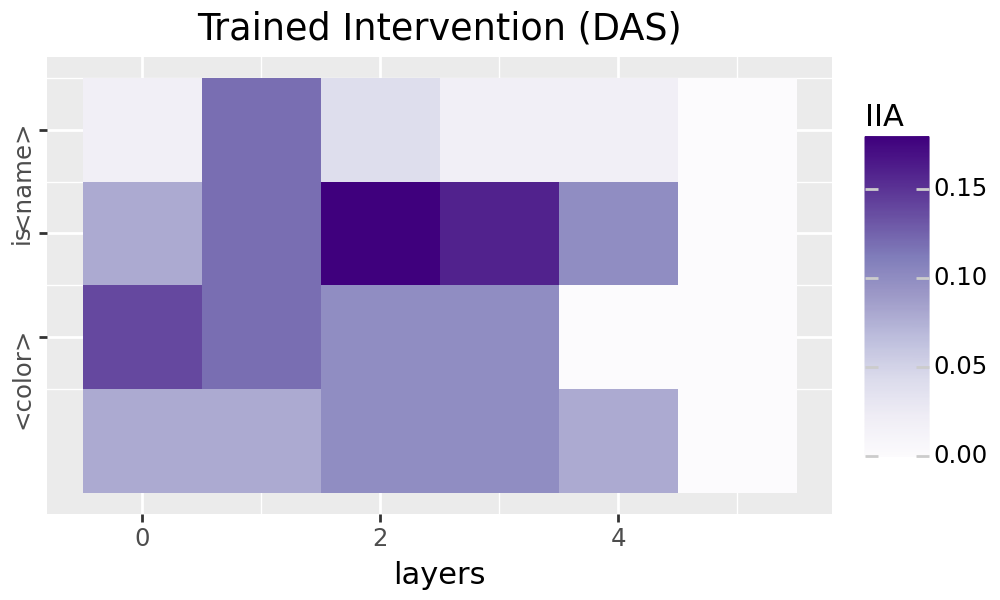

In [18]:
df["layer"] = df["layer"].astype(int)
df["pos"] = df["position"].astype(int)
df["IIA"] = df["iia"].astype(float)

custom_labels = ["<name>", "is", "<color>"]
breaks = [0, 1, 2]

plot = (
    ggplot(df, aes(x="layer", y="pos"))
    + geom_tile(aes(fill="IIA"))
    + scale_fill_cmap("Purples") + xlab("layers")
    + scale_y_reverse(
        limits = (-0.5, 3.5),
        breaks=breaks, labels=custom_labels)
    + theme(figure_size=(5, 3)) + ylab("")
    + theme(axis_text_y  = element_text(angle = 90, hjust = 1))
    + ggtitle("Trained Intervention (DAS)")
)

display(plot)

## Probing

We'll define a dummy intervention `CollectActivation` to collect activations and train a simple probe.

In [19]:
def probing_config(intervention_site, layer):
    """Generate intervention config."""

    # init
    config = pv.IntervenableConfig([{
        "layer": layer,
        "component": intervention_site,
        "intervention_type": pv.CollectIntervention,
    }])
    return config

This is the training loop.

In [20]:
# intervention settings
stats = []
num_layers = gpt.config.num_hidden_layers

label_mapping = {28659: 0, 27250: 1, 11707: 2, 11300: 3}

import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.neural_network import MLPClassifier
import torch
from tqdm import tqdm
import pandas as pd
from collections import Counter

# ===================================================
# 1) VERIFYING THE LABEL_MAPPING
# ===================================================
# Print tokens for the specified words to ensure that
# the IDs match the defined label_mapping.
label_mapping = {
    28659: 0,
    27250: 1,
    11707: 2,
    11300: 3
}

print("=== DEBUG: label_mapping and actual model tokens ===")
words_to_check = ["mouse", "cat", "wolf", "cats"]
for word in words_to_check:
    tokens = tokenizer.encode(word, add_special_tokens=False)
    print(f"'{word}' -> {tokens}")
print("label_mapping:", label_mapping)
print("===================================================\n")

# Debug input data
print("\nSample data from trainset:")
for ex in trainset[:5]:
    print("Base sample:", ex.base)
    print("Source sample:", ex.src)
    print("Base label:", ex.base_label, "->", tokenizer.decode([ex.base_label]))
    print("Source label:", ex.src_label, "->", tokenizer.decode([ex.src_label]))

print("\nSample data from evalset:")
for ex in evalset[:5]:
    print("Base sample:", ex.base)
    print("Source sample:", ex.src)
    print("Base label:", ex.base_label, "->", tokenizer.decode([ex.base_label]))
    print("Source label:", ex.src_label, "->", tokenizer.decode([ex.src_label]))

# ===================================================
# 2) DATASET DIAGNOSTICS (trainset, evalset)
# ===================================================

def remove_duplicates(trainset, evalset):
    # Convert trainset and evalset to sets of tuples for comparison
    train_samples_str = set([
        (tuple(ex.base["input_ids"][0].tolist()), tuple(ex.src["input_ids"][0].tolist()))
        for ex in trainset
    ])
    eval_samples_str = set([
        (tuple(ex.base["input_ids"][0].tolist()), tuple(ex.src["input_ids"][0].tolist()))
        for ex in evalset
    ])

    # Find duplicates between trainset and evalset
    common = train_samples_str.intersection(eval_samples_str)
    print(f"\nNumber of duplicates between trainset and evalset: {len(common)}")

    # Remove duplicates from evalset if any
    if len(common) > 0:
        print("WARNING: Removing duplicates from evalset...\n")
        evalset = [
            ex for ex in evalset
            if (tuple(ex.base["input_ids"][0].tolist()), tuple(ex.src["input_ids"][0].tolist())) not in common
        ]
    else:
        print("OK: No duplicates between trainset and evalset.\n")

    return trainset, evalset

# 1) Remove duplicates
trainset, evalset = remove_duplicates(trainset, evalset)

# 2) Build label lists for trainset and evalset
train_text_labels = []
for ex in trainset:
    train_text_labels.append(ex.base_label)
    train_text_labels.append(ex.src_label)

eval_text_labels = []
for ex in evalset:
    eval_text_labels.append(ex.base_label)
    eval_text_labels.append(ex.src_label)

# Debug: Check label distribution
print("Label distribution (IDs) in trainset:", Counter(train_text_labels))
print("Label distribution (IDs) in evalset:", Counter(eval_text_labels))

# 3) Balance the dataset
balanced_trainset = []
for label in set(train_text_labels):
    label_samples = [ex for ex in trainset if ex.base_label == label or ex.src_label == label]
    balanced_trainset.extend(resample(label_samples, replace=True, n_samples=200, random_state=42))
trainset = balanced_trainset

print(f"\nAfter balancing: Number of samples in trainset: {len(trainset)}")
print(f"Number of samples in evalset: {len(evalset)}")

# Count label occurrences in train and eval datasets
train_text_labels = []
for ex in trainset:
    train_text_labels.append(ex.base_label)
    train_text_labels.append(ex.src_label)

eval_text_labels = []
for ex in evalset:
    eval_text_labels.append(ex.base_label)
    eval_text_labels.append(ex.src_label)

print("Label distribution (IDs) in trainset:", Counter(train_text_labels))
print("Label distribution (IDs) in evalset:", Counter(eval_text_labels))

# ===================================================
# 3) MAIN PROBING CODE
# ===================================================
stats = []
num_layers = gpt.config.num_hidden_layers

# Ensure label_mapping IDs match the above tokens
with torch.no_grad():
    for layer in range(num_layers):
        for position in range(4):
            print(f"==== layer: {layer}, position: {position} ====")

            # Set up intervenable model
            config = probing_config("block_output", layer)
            intervenable = pv.IntervenableModel(config, gpt)
            intervenable.set_device(device)
            intervenable.disable_model_gradients()

            # ===========================
            # COLLECT TRAINING DATA
            # ===========================
            train_activations, train_labels_ids = [], []
            iterator = tqdm(trainset, desc="Collecting TRAIN activations")
            for example in iterator:
                base_outputs, _ = intervenable(
                    example.base,
                    unit_locations={"base": position},
                )
                base_activations = base_outputs[1][0]

                src_outputs, _ = intervenable(
                    example.src,
                    unit_locations={"base": position},
                )
                src_activations = src_outputs[1][0]

                train_activations.extend([
                    base_activations.detach()[0].cpu().numpy(),
                    src_activations.detach()[0].cpu().numpy()
                ])
                train_labels_ids.extend([example.base_label, example.src_label])

            # Map train labels using label_mapping
            train_labels_mapped = []
            for lb in train_labels_ids:
                if isinstance(lb, list):
                    lb = tuple(lb)
                if lb not in label_mapping:
                    continue
                train_labels_mapped.append(label_mapping[lb])

            train_activations = np.array(train_activations)
            train_labels_mapped = np.array(train_labels_mapped)

            scaler = StandardScaler()
            train_activations_scaled = scaler.fit_transform(train_activations)

            # Collect activation statistics
            activations_sample = []
            for example in trainset[:5]:
                base_outputs, _ = intervenable(
                    example.base,
                    unit_locations={"base": 0},
                )
                activations_sample.append(base_outputs[1][0].detach().cpu().numpy())

            print("\nActivations (layer 0, position 0):", activations_sample[:3])
            print("Mean activation:", np.mean(activations_sample))
            print("Standard deviation:", np.std(activations_sample))

            # ===========================
            # TRAINING LOGISTIC REGRESSION / MLP
            # ===========================
            mlp = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=500, alpha=1e-4, early_stopping=True, random_state=42)
            mlp.fit(train_activations_scaled, train_labels_mapped)

            # =========================
            # COLLECT EVAL DATA
            # =========================
            eval_activations, eval_labels_ids = [], []
            iterator = tqdm(evalset, desc="Collecting EVAL activations")
            for example in iterator:
                base_outputs, _ = intervenable(
                    example.base,
                    unit_locations={"base": position},
                )
                base_activations = base_outputs[1][0]

                src_outputs, _ = intervenable(
                    example.src,
                    unit_locations={"base": position},
                )
                src_activations = src_outputs[1][0]

                eval_activations.extend([
                    base_activations.detach()[0].cpu().numpy(),
                    src_activations.detach()[0].cpu().numpy()
                ])
                eval_labels_ids.extend([example.base_label, example.src_label])

            eval_labels_mapped = []
            for lb in eval_labels_ids:
                if isinstance(lb, list):
                    lb = tuple(lb)
                if lb not in label_mapping:
                    continue
                eval_labels_mapped.append(label_mapping[lb])

            eval_activations = np.array(eval_activations)
            eval_labels_mapped = np.array(eval_labels_mapped)

            eval_activations_scaled = scaler.transform(eval_activations)

            preds = mlp.predict(eval_activations_scaled)
            acc = (preds == eval_labels_mapped).mean()
            f1 = f1_score(eval_labels_mapped, preds, average="micro")

            stats.append({
                "layer": layer,
                "position": position,
                "acc": acc,
                "f1": f1
            })
            print(f"[layer={layer}, pos={position}] ACC: {acc:.3%}, F1: {f1:.3f}")

            # Debugging predictions
            for i, (pred, true) in enumerate(zip(preds, eval_labels_mapped)):
                if pred != true:
                    print(f"Error in sample {i}: pred={pred}, true={true}")

# SAVE RESULTS
df = pd.DataFrame(stats)
print("\nResults statistics (first 5 rows):")
print(df.head(5))


=== DEBUG: label_mapping and actual model tokens ===
'mouse' -> [19618]
'cat' -> [8076]
'wolf' -> [40995]
'cats' -> [38718]
label_mapping: {28659: 0, 27250: 1, 11707: 2, 11300: 3}


Sample data from trainset:
Base sample: {'input_ids': tensor([[35119,   310, 11978,    15, 32817,   310,   247, 27405,    15, 13916,
           310,   247, 27405,    15, 44402,   310,   247,  1863,   266,    15,
         13916,   310, 11978,    15, 44402,   310,  4759,    15, 10246, 10984,
           310,   247, 40096,    15, 10246, 10984,   310,  8862,    15, 14468,
           310,   247,  1863,   266,    15, 32817,   310,   209]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0')}
Source sample: {'input_ids': tensor([[31080, 10984,   310,  3168,    15, 14468,   310,   247, 13882,  2610,
            15, 32817,   310,   247, 1388


Activations (layer 0, position 0): [array([[ 9.54790592e-01,  3.62639427e-01,  9.32809263e-02,
        -3.57578754e-01,  2.54446983e-01,  3.59776735e-01,
         5.47914863e-01, -2.93951035e-02, -5.57637930e-01,
        -7.48532891e-01, -5.77677637e-02,  2.45828703e-01,
         3.65632266e-01,  2.81932771e-01, -1.78569645e-01,
        -2.98241854e-01, -4.33779180e-01, -2.03222036e-03,
         3.34734321e-01, -6.09865636e-02,  4.50167477e-01,
         5.14601111e-01, -5.21959186e-01,  8.19658160e-01,
        -3.86447579e-01, -4.79984999e-01, -4.86413717e-01,
         3.39503884e-01, -2.80564368e-01,  2.27956429e-01,
         4.15651053e-02, -7.66095281e-01, -7.12602884e-02,
        -1.19295791e-01, -3.06139469e-01,  5.01044393e-02,
         7.07164466e-01, -1.21050932e-01,  6.50847793e-01,
         3.67456079e-02,  2.58920670e-01,  1.17062971e-01,
        -5.47724724e-01,  7.18075991e-01,  5.51084101e-01,
        -2.72975489e-02, -2.86827773e-01, -2.16370955e-01,
        -9.13730860

[layer=0, pos=0] ACC: 22.826%, F1: 0.228
Error in sample 0: pred=0, true=2
Error in sample 1: pred=0, true=1
Error in sample 2: pred=0, true=3
Error in sample 3: pred=2, true=0
Error in sample 4: pred=0, true=1
Error in sample 5: pred=0, true=2
Error in sample 7: pred=3, true=1
Error in sample 9: pred=0, true=1
Error in sample 10: pred=0, true=2
Error in sample 11: pred=2, true=1
Error in sample 12: pred=3, true=2
Error in sample 13: pred=3, true=1
Error in sample 14: pred=3, true=1
Error in sample 15: pred=3, true=2
Error in sample 16: pred=0, true=1
Error in sample 17: pred=3, true=2
Error in sample 18: pred=3, true=2
Error in sample 19: pred=3, true=1
Error in sample 20: pred=3, true=2
Error in sample 21: pred=3, true=1
Error in sample 22: pred=0, true=1
Error in sample 23: pred=3, true=2
Error in sample 25: pred=2, true=1
Error in sample 26: pred=2, true=0
Error in sample 28: pred=0, true=1
Error in sample 29: pred=0, true=2
Error in sample 31: pred=3, true=1
Error in sample 32: pr


Activations (layer 0, position 0): [array([[ 9.54790592e-01,  3.62639427e-01,  9.32809263e-02,
        -3.57578754e-01,  2.54446983e-01,  3.59776735e-01,
         5.47914863e-01, -2.93951035e-02, -5.57637930e-01,
        -7.48532891e-01, -5.77677637e-02,  2.45828703e-01,
         3.65632266e-01,  2.81932771e-01, -1.78569645e-01,
        -2.98241854e-01, -4.33779180e-01, -2.03222036e-03,
         3.34734321e-01, -6.09865636e-02,  4.50167477e-01,
         5.14601111e-01, -5.21959186e-01,  8.19658160e-01,
        -3.86447579e-01, -4.79984999e-01, -4.86413717e-01,
         3.39503884e-01, -2.80564368e-01,  2.27956429e-01,
         4.15651053e-02, -7.66095281e-01, -7.12602884e-02,
        -1.19295791e-01, -3.06139469e-01,  5.01044393e-02,
         7.07164466e-01, -1.21050932e-01,  6.50847793e-01,
         3.67456079e-02,  2.58920670e-01,  1.17062971e-01,
        -5.47724724e-01,  7.18075991e-01,  5.51084101e-01,
        -2.72975489e-02, -2.86827773e-01, -2.16370955e-01,
        -9.13730860

[layer=0, pos=1] ACC: 22.826%, F1: 0.228
Error in sample 0: pred=0, true=2
Error in sample 1: pred=0, true=1
Error in sample 2: pred=0, true=3
Error in sample 3: pred=2, true=0
Error in sample 4: pred=0, true=1
Error in sample 5: pred=0, true=2
Error in sample 7: pred=3, true=1
Error in sample 9: pred=0, true=1
Error in sample 10: pred=0, true=2
Error in sample 11: pred=2, true=1
Error in sample 12: pred=3, true=2
Error in sample 13: pred=3, true=1
Error in sample 14: pred=3, true=1
Error in sample 15: pred=3, true=2
Error in sample 16: pred=0, true=1
Error in sample 17: pred=3, true=2
Error in sample 18: pred=3, true=2
Error in sample 19: pred=3, true=1
Error in sample 20: pred=3, true=2
Error in sample 21: pred=3, true=1
Error in sample 22: pred=0, true=1
Error in sample 23: pred=3, true=2
Error in sample 25: pred=2, true=1
Error in sample 26: pred=2, true=0
Error in sample 28: pred=0, true=1
Error in sample 29: pred=0, true=2
Error in sample 31: pred=3, true=1
Error in sample 32: pr


Activations (layer 0, position 0): [array([[ 9.54790592e-01,  3.62639427e-01,  9.32809263e-02,
        -3.57578754e-01,  2.54446983e-01,  3.59776735e-01,
         5.47914863e-01, -2.93951035e-02, -5.57637930e-01,
        -7.48532891e-01, -5.77677637e-02,  2.45828703e-01,
         3.65632266e-01,  2.81932771e-01, -1.78569645e-01,
        -2.98241854e-01, -4.33779180e-01, -2.03222036e-03,
         3.34734321e-01, -6.09865636e-02,  4.50167477e-01,
         5.14601111e-01, -5.21959186e-01,  8.19658160e-01,
        -3.86447579e-01, -4.79984999e-01, -4.86413717e-01,
         3.39503884e-01, -2.80564368e-01,  2.27956429e-01,
         4.15651053e-02, -7.66095281e-01, -7.12602884e-02,
        -1.19295791e-01, -3.06139469e-01,  5.01044393e-02,
         7.07164466e-01, -1.21050932e-01,  6.50847793e-01,
         3.67456079e-02,  2.58920670e-01,  1.17062971e-01,
        -5.47724724e-01,  7.18075991e-01,  5.51084101e-01,
        -2.72975489e-02, -2.86827773e-01, -2.16370955e-01,
        -9.13730860

[layer=0, pos=2] ACC: 39.130%, F1: 0.391
Error in sample 1: pred=2, true=1
Error in sample 2: pred=1, true=3
Error in sample 3: pred=2, true=0
Error in sample 4: pred=0, true=1
Error in sample 7: pred=3, true=1
Error in sample 11: pred=2, true=1
Error in sample 12: pred=3, true=2
Error in sample 13: pred=3, true=1
Error in sample 14: pred=3, true=1
Error in sample 15: pred=3, true=2
Error in sample 17: pred=3, true=2
Error in sample 18: pred=3, true=2
Error in sample 19: pred=3, true=1
Error in sample 20: pred=3, true=2
Error in sample 21: pred=3, true=1
Error in sample 22: pred=2, true=1
Error in sample 23: pred=3, true=2
Error in sample 25: pred=2, true=1
Error in sample 26: pred=2, true=0
Error in sample 28: pred=2, true=1
Error in sample 31: pred=3, true=1
Error in sample 33: pred=0, true=1
Error in sample 34: pred=3, true=1
Error in sample 37: pred=3, true=1
Error in sample 38: pred=2, true=1
Error in sample 40: pred=3, true=1
Error in sample 41: pred=3, true=2
Error in sample 42:


Activations (layer 0, position 0): [array([[ 9.54790592e-01,  3.62639427e-01,  9.32809263e-02,
        -3.57578754e-01,  2.54446983e-01,  3.59776735e-01,
         5.47914863e-01, -2.93951035e-02, -5.57637930e-01,
        -7.48532891e-01, -5.77677637e-02,  2.45828703e-01,
         3.65632266e-01,  2.81932771e-01, -1.78569645e-01,
        -2.98241854e-01, -4.33779180e-01, -2.03222036e-03,
         3.34734321e-01, -6.09865636e-02,  4.50167477e-01,
         5.14601111e-01, -5.21959186e-01,  8.19658160e-01,
        -3.86447579e-01, -4.79984999e-01, -4.86413717e-01,
         3.39503884e-01, -2.80564368e-01,  2.27956429e-01,
         4.15651053e-02, -7.66095281e-01, -7.12602884e-02,
        -1.19295791e-01, -3.06139469e-01,  5.01044393e-02,
         7.07164466e-01, -1.21050932e-01,  6.50847793e-01,
         3.67456079e-02,  2.58920670e-01,  1.17062971e-01,
        -5.47724724e-01,  7.18075991e-01,  5.51084101e-01,
        -2.72975489e-02, -2.86827773e-01, -2.16370955e-01,
        -9.13730860

[layer=0, pos=3] ACC: 45.652%, F1: 0.457
Error in sample 1: pred=2, true=1
Error in sample 2: pred=1, true=3
Error in sample 3: pred=2, true=0
Error in sample 4: pred=0, true=1
Error in sample 7: pred=0, true=1
Error in sample 11: pred=2, true=1
Error in sample 12: pred=3, true=2
Error in sample 14: pred=2, true=1
Error in sample 15: pred=3, true=2
Error in sample 17: pred=3, true=2
Error in sample 18: pred=3, true=2
Error in sample 19: pred=3, true=1
Error in sample 21: pred=3, true=1
Error in sample 22: pred=2, true=1
Error in sample 23: pred=3, true=2
Error in sample 25: pred=2, true=1
Error in sample 26: pred=2, true=0
Error in sample 28: pred=2, true=1
Error in sample 30: pred=3, true=2
Error in sample 31: pred=0, true=1
Error in sample 33: pred=0, true=1
Error in sample 35: pred=3, true=2
Error in sample 38: pred=2, true=1
Error in sample 39: pred=3, true=2
Error in sample 40: pred=0, true=1
Error in sample 41: pred=3, true=2
Error in sample 42: pred=3, true=2
Error in sample 46:


Activations (layer 0, position 0): [array([[ 1.51563096e+00,  1.79514587e-01,  8.79586786e-02,
        -1.69950891e+00,  5.65601408e-01,  2.36302376e+00,
         8.31362724e-01, -1.33039355e+00,  2.40457177e-01,
        -1.13273764e+00, -1.61774433e+00, -4.93901670e-01,
         1.72588933e+00,  2.18981519e-01, -4.55281854e-01,
         1.11369371e-01, -7.38580763e-01,  1.96118188e+00,
         8.74089360e-01,  9.97390151e-02, -4.77177918e-01,
        -1.68626726e+00, -1.44804120e-01,  9.17975998e+00,
        -5.35280228e-01,  3.36485147e-01, -2.49925923e+00,
         7.28926539e-01,  4.86411452e-01,  3.13540339e-01,
        -7.91772157e-02, -1.47767067e-02,  2.88008988e-01,
         5.10487795e-01,  1.05554569e+00,  2.17359042e+00,
         1.83613348e+00,  5.57576641e-02, -8.19806457e-01,
        -1.70731068e+00,  7.75499284e-01, -6.12536013e-01,
         1.35351646e+00,  2.04496098e+00,  1.41435075e+00,
         8.62490356e-01, -8.16742897e-01, -1.19340563e+00,
         1.36132729

[layer=1, pos=0] ACC: 32.609%, F1: 0.326
Error in sample 0: pred=0, true=2
Error in sample 1: pred=0, true=1
Error in sample 2: pred=0, true=3
Error in sample 3: pred=2, true=0
Error in sample 4: pred=0, true=1
Error in sample 5: pred=0, true=2
Error in sample 9: pred=0, true=1
Error in sample 10: pred=0, true=2
Error in sample 11: pred=2, true=1
Error in sample 12: pred=3, true=2
Error in sample 14: pred=3, true=1
Error in sample 15: pred=1, true=2
Error in sample 16: pred=0, true=1
Error in sample 17: pred=3, true=2
Error in sample 18: pred=3, true=2
Error in sample 19: pred=3, true=1
Error in sample 20: pred=3, true=2
Error in sample 21: pred=3, true=1
Error in sample 22: pred=0, true=1
Error in sample 23: pred=1, true=2
Error in sample 25: pred=2, true=1
Error in sample 26: pred=2, true=0
Error in sample 27: pred=1, true=3
Error in sample 28: pred=0, true=1
Error in sample 29: pred=0, true=2
Error in sample 32: pred=0, true=2
Error in sample 33: pred=0, true=1
Error in sample 36: p


Activations (layer 0, position 0): [array([[ 1.51563096e+00,  1.79514587e-01,  8.79586786e-02,
        -1.69950891e+00,  5.65601408e-01,  2.36302376e+00,
         8.31362724e-01, -1.33039355e+00,  2.40457177e-01,
        -1.13273764e+00, -1.61774433e+00, -4.93901670e-01,
         1.72588933e+00,  2.18981519e-01, -4.55281854e-01,
         1.11369371e-01, -7.38580763e-01,  1.96118188e+00,
         8.74089360e-01,  9.97390151e-02, -4.77177918e-01,
        -1.68626726e+00, -1.44804120e-01,  9.17975998e+00,
        -5.35280228e-01,  3.36485147e-01, -2.49925923e+00,
         7.28926539e-01,  4.86411452e-01,  3.13540339e-01,
        -7.91772157e-02, -1.47767067e-02,  2.88008988e-01,
         5.10487795e-01,  1.05554569e+00,  2.17359042e+00,
         1.83613348e+00,  5.57576641e-02, -8.19806457e-01,
        -1.70731068e+00,  7.75499284e-01, -6.12536013e-01,
         1.35351646e+00,  2.04496098e+00,  1.41435075e+00,
         8.62490356e-01, -8.16742897e-01, -1.19340563e+00,
         1.36132729

[layer=1, pos=1] ACC: 22.826%, F1: 0.228
Error in sample 0: pred=0, true=2
Error in sample 1: pred=0, true=1
Error in sample 2: pred=0, true=3
Error in sample 3: pred=2, true=0
Error in sample 4: pred=0, true=1
Error in sample 5: pred=0, true=2
Error in sample 7: pred=3, true=1
Error in sample 9: pred=0, true=1
Error in sample 10: pred=0, true=2
Error in sample 11: pred=2, true=1
Error in sample 12: pred=3, true=2
Error in sample 13: pred=3, true=1
Error in sample 14: pred=3, true=1
Error in sample 15: pred=3, true=2
Error in sample 16: pred=0, true=1
Error in sample 17: pred=3, true=2
Error in sample 18: pred=3, true=2
Error in sample 19: pred=3, true=1
Error in sample 20: pred=3, true=2
Error in sample 21: pred=3, true=1
Error in sample 22: pred=0, true=1
Error in sample 23: pred=3, true=2
Error in sample 25: pred=2, true=1
Error in sample 26: pred=2, true=0
Error in sample 28: pred=0, true=1
Error in sample 29: pred=0, true=2
Error in sample 31: pred=3, true=1
Error in sample 32: pr


Activations (layer 0, position 0): [array([[ 1.51563096e+00,  1.79514587e-01,  8.79586786e-02,
        -1.69950891e+00,  5.65601408e-01,  2.36302376e+00,
         8.31362724e-01, -1.33039355e+00,  2.40457177e-01,
        -1.13273764e+00, -1.61774433e+00, -4.93901670e-01,
         1.72588933e+00,  2.18981519e-01, -4.55281854e-01,
         1.11369371e-01, -7.38580763e-01,  1.96118188e+00,
         8.74089360e-01,  9.97390151e-02, -4.77177918e-01,
        -1.68626726e+00, -1.44804120e-01,  9.17975998e+00,
        -5.35280228e-01,  3.36485147e-01, -2.49925923e+00,
         7.28926539e-01,  4.86411452e-01,  3.13540339e-01,
        -7.91772157e-02, -1.47767067e-02,  2.88008988e-01,
         5.10487795e-01,  1.05554569e+00,  2.17359042e+00,
         1.83613348e+00,  5.57576641e-02, -8.19806457e-01,
        -1.70731068e+00,  7.75499284e-01, -6.12536013e-01,
         1.35351646e+00,  2.04496098e+00,  1.41435075e+00,
         8.62490356e-01, -8.16742897e-01, -1.19340563e+00,
         1.36132729

[layer=1, pos=2] ACC: 39.130%, F1: 0.391
Error in sample 1: pred=2, true=1
Error in sample 2: pred=1, true=3
Error in sample 3: pred=2, true=0
Error in sample 4: pred=0, true=1
Error in sample 7: pred=3, true=1
Error in sample 11: pred=2, true=1
Error in sample 12: pred=3, true=2
Error in sample 13: pred=3, true=1
Error in sample 14: pred=3, true=1
Error in sample 15: pred=3, true=2
Error in sample 17: pred=3, true=2
Error in sample 18: pred=3, true=2
Error in sample 19: pred=3, true=1
Error in sample 20: pred=3, true=2
Error in sample 21: pred=3, true=1
Error in sample 22: pred=2, true=1
Error in sample 23: pred=3, true=2
Error in sample 25: pred=2, true=1
Error in sample 26: pred=2, true=0
Error in sample 28: pred=2, true=1
Error in sample 31: pred=3, true=1
Error in sample 33: pred=0, true=1
Error in sample 34: pred=3, true=1
Error in sample 37: pred=3, true=1
Error in sample 38: pred=2, true=1
Error in sample 40: pred=3, true=1
Error in sample 41: pred=3, true=2
Error in sample 42:


Activations (layer 0, position 0): [array([[ 1.51563096e+00,  1.79514587e-01,  8.79586786e-02,
        -1.69950891e+00,  5.65601408e-01,  2.36302376e+00,
         8.31362724e-01, -1.33039355e+00,  2.40457177e-01,
        -1.13273764e+00, -1.61774433e+00, -4.93901670e-01,
         1.72588933e+00,  2.18981519e-01, -4.55281854e-01,
         1.11369371e-01, -7.38580763e-01,  1.96118188e+00,
         8.74089360e-01,  9.97390151e-02, -4.77177918e-01,
        -1.68626726e+00, -1.44804120e-01,  9.17975998e+00,
        -5.35280228e-01,  3.36485147e-01, -2.49925923e+00,
         7.28926539e-01,  4.86411452e-01,  3.13540339e-01,
        -7.91772157e-02, -1.47767067e-02,  2.88008988e-01,
         5.10487795e-01,  1.05554569e+00,  2.17359042e+00,
         1.83613348e+00,  5.57576641e-02, -8.19806457e-01,
        -1.70731068e+00,  7.75499284e-01, -6.12536013e-01,
         1.35351646e+00,  2.04496098e+00,  1.41435075e+00,
         8.62490356e-01, -8.16742897e-01, -1.19340563e+00,
         1.36132729

[layer=1, pos=3] ACC: 47.826%, F1: 0.478
Error in sample 1: pred=2, true=1
Error in sample 2: pred=2, true=3
Error in sample 4: pred=0, true=1
Error in sample 7: pred=0, true=1
Error in sample 11: pred=2, true=1
Error in sample 12: pred=1, true=2
Error in sample 14: pred=2, true=1
Error in sample 15: pred=3, true=2
Error in sample 16: pred=2, true=1
Error in sample 17: pred=3, true=2
Error in sample 18: pred=3, true=2
Error in sample 22: pred=2, true=1
Error in sample 23: pred=3, true=2
Error in sample 24: pred=0, true=2
Error in sample 25: pred=0, true=1
Error in sample 28: pred=2, true=1
Error in sample 31: pred=0, true=1
Error in sample 33: pred=0, true=1
Error in sample 38: pred=2, true=1
Error in sample 40: pred=0, true=1
Error in sample 41: pred=3, true=2
Error in sample 42: pred=3, true=2
Error in sample 43: pred=2, true=1
Error in sample 44: pred=2, true=1
Error in sample 46: pred=3, true=1
Error in sample 50: pred=3, true=2
Error in sample 51: pred=2, true=1
Error in sample 52


Activations (layer 0, position 0): [array([[ 1.63455319e+00, -8.82312834e-01,  9.26468670e-01,
         4.37613010e-01,  1.41689467e+00,  2.06218481e-01,
         2.05280185e-01, -2.44642448e+00, -4.73323762e-01,
         6.72096968e-01, -1.23384190e+00, -6.18211269e-01,
         5.68591118e-01,  8.81164968e-01,  1.03167009e+00,
        -1.73769474e-01, -1.06405425e+00, -5.61099291e-01,
         1.13886905e+00, -2.60724783e-01,  2.06876683e+00,
        -7.21571445e-01, -6.27051592e-01,  8.29065857e+01,
         1.07510042e+00,  2.99778849e-01, -1.95732498e+00,
        -3.71847153e-01,  6.36155725e-01, -5.87889194e-01,
         1.05855215e+00, -1.77991271e+00,  1.05281627e+00,
        -2.82094061e-01,  1.80151272e+00, -1.81627274e-02,
         3.47815275e-01, -1.22547817e+00, -2.84799004e+00,
        -2.66754532e+00,  5.52012205e-01, -6.82236254e-01,
         6.37985408e-01,  6.22722149e-01, -1.86689138e-01,
         1.18541682e+00, -6.13002419e-01, -6.44836068e-01,
        -2.30796695

[layer=2, pos=0] ACC: 32.609%, F1: 0.326
Error in sample 0: pred=0, true=2
Error in sample 1: pred=0, true=1
Error in sample 2: pred=0, true=3
Error in sample 3: pred=2, true=0
Error in sample 4: pred=0, true=1
Error in sample 5: pred=0, true=2
Error in sample 9: pred=0, true=1
Error in sample 10: pred=0, true=2
Error in sample 11: pred=2, true=1
Error in sample 12: pred=3, true=2
Error in sample 14: pred=3, true=1
Error in sample 15: pred=1, true=2
Error in sample 16: pred=0, true=1
Error in sample 17: pred=3, true=2
Error in sample 18: pred=3, true=2
Error in sample 19: pred=3, true=1
Error in sample 20: pred=3, true=2
Error in sample 21: pred=3, true=1
Error in sample 22: pred=0, true=1
Error in sample 23: pred=1, true=2
Error in sample 25: pred=2, true=1
Error in sample 26: pred=2, true=0
Error in sample 27: pred=1, true=3
Error in sample 28: pred=0, true=1
Error in sample 29: pred=0, true=2
Error in sample 32: pred=0, true=2
Error in sample 33: pred=0, true=1
Error in sample 36: p


Activations (layer 0, position 0): [array([[ 1.63455319e+00, -8.82312834e-01,  9.26468670e-01,
         4.37613010e-01,  1.41689467e+00,  2.06218481e-01,
         2.05280185e-01, -2.44642448e+00, -4.73323762e-01,
         6.72096968e-01, -1.23384190e+00, -6.18211269e-01,
         5.68591118e-01,  8.81164968e-01,  1.03167009e+00,
        -1.73769474e-01, -1.06405425e+00, -5.61099291e-01,
         1.13886905e+00, -2.60724783e-01,  2.06876683e+00,
        -7.21571445e-01, -6.27051592e-01,  8.29065857e+01,
         1.07510042e+00,  2.99778849e-01, -1.95732498e+00,
        -3.71847153e-01,  6.36155725e-01, -5.87889194e-01,
         1.05855215e+00, -1.77991271e+00,  1.05281627e+00,
        -2.82094061e-01,  1.80151272e+00, -1.81627274e-02,
         3.47815275e-01, -1.22547817e+00, -2.84799004e+00,
        -2.66754532e+00,  5.52012205e-01, -6.82236254e-01,
         6.37985408e-01,  6.22722149e-01, -1.86689138e-01,
         1.18541682e+00, -6.13002419e-01, -6.44836068e-01,
        -2.30796695

[layer=2, pos=1] ACC: 22.826%, F1: 0.228
Error in sample 0: pred=0, true=2
Error in sample 1: pred=0, true=1
Error in sample 2: pred=0, true=3
Error in sample 3: pred=2, true=0
Error in sample 4: pred=0, true=1
Error in sample 5: pred=0, true=2
Error in sample 7: pred=3, true=1
Error in sample 9: pred=0, true=1
Error in sample 10: pred=0, true=2
Error in sample 11: pred=2, true=1
Error in sample 12: pred=3, true=2
Error in sample 13: pred=3, true=1
Error in sample 14: pred=3, true=1
Error in sample 15: pred=3, true=2
Error in sample 16: pred=0, true=1
Error in sample 17: pred=3, true=2
Error in sample 18: pred=3, true=2
Error in sample 19: pred=3, true=1
Error in sample 20: pred=3, true=2
Error in sample 21: pred=3, true=1
Error in sample 22: pred=0, true=1
Error in sample 23: pred=3, true=2
Error in sample 25: pred=2, true=1
Error in sample 26: pred=2, true=0
Error in sample 28: pred=0, true=1
Error in sample 29: pred=0, true=2
Error in sample 31: pred=3, true=1
Error in sample 32: pr


Activations (layer 0, position 0): [array([[ 1.63455319e+00, -8.82312834e-01,  9.26468670e-01,
         4.37613010e-01,  1.41689467e+00,  2.06218481e-01,
         2.05280185e-01, -2.44642448e+00, -4.73323762e-01,
         6.72096968e-01, -1.23384190e+00, -6.18211269e-01,
         5.68591118e-01,  8.81164968e-01,  1.03167009e+00,
        -1.73769474e-01, -1.06405425e+00, -5.61099291e-01,
         1.13886905e+00, -2.60724783e-01,  2.06876683e+00,
        -7.21571445e-01, -6.27051592e-01,  8.29065857e+01,
         1.07510042e+00,  2.99778849e-01, -1.95732498e+00,
        -3.71847153e-01,  6.36155725e-01, -5.87889194e-01,
         1.05855215e+00, -1.77991271e+00,  1.05281627e+00,
        -2.82094061e-01,  1.80151272e+00, -1.81627274e-02,
         3.47815275e-01, -1.22547817e+00, -2.84799004e+00,
        -2.66754532e+00,  5.52012205e-01, -6.82236254e-01,
         6.37985408e-01,  6.22722149e-01, -1.86689138e-01,
         1.18541682e+00, -6.13002419e-01, -6.44836068e-01,
        -2.30796695

[layer=2, pos=2] ACC: 34.783%, F1: 0.348
Error in sample 1: pred=2, true=1
Error in sample 2: pred=0, true=3
Error in sample 3: pred=2, true=0
Error in sample 4: pred=0, true=1
Error in sample 7: pred=3, true=1
Error in sample 11: pred=2, true=1
Error in sample 12: pred=3, true=2
Error in sample 13: pred=3, true=1
Error in sample 14: pred=3, true=1
Error in sample 15: pred=3, true=2
Error in sample 16: pred=0, true=1
Error in sample 17: pred=3, true=2
Error in sample 18: pred=3, true=2
Error in sample 19: pred=3, true=1
Error in sample 20: pred=3, true=2
Error in sample 21: pred=3, true=1
Error in sample 22: pred=2, true=1
Error in sample 23: pred=3, true=2
Error in sample 25: pred=2, true=1
Error in sample 26: pred=2, true=0
Error in sample 28: pred=2, true=1
Error in sample 31: pred=3, true=1
Error in sample 33: pred=0, true=1
Error in sample 34: pred=3, true=1
Error in sample 37: pred=3, true=1
Error in sample 38: pred=2, true=1
Error in sample 40: pred=3, true=1
Error in sample 41:


Activations (layer 0, position 0): [array([[ 1.63455319e+00, -8.82312834e-01,  9.26468670e-01,
         4.37613010e-01,  1.41689467e+00,  2.06218481e-01,
         2.05280185e-01, -2.44642448e+00, -4.73323762e-01,
         6.72096968e-01, -1.23384190e+00, -6.18211269e-01,
         5.68591118e-01,  8.81164968e-01,  1.03167009e+00,
        -1.73769474e-01, -1.06405425e+00, -5.61099291e-01,
         1.13886905e+00, -2.60724783e-01,  2.06876683e+00,
        -7.21571445e-01, -6.27051592e-01,  8.29065857e+01,
         1.07510042e+00,  2.99778849e-01, -1.95732498e+00,
        -3.71847153e-01,  6.36155725e-01, -5.87889194e-01,
         1.05855215e+00, -1.77991271e+00,  1.05281627e+00,
        -2.82094061e-01,  1.80151272e+00, -1.81627274e-02,
         3.47815275e-01, -1.22547817e+00, -2.84799004e+00,
        -2.66754532e+00,  5.52012205e-01, -6.82236254e-01,
         6.37985408e-01,  6.22722149e-01, -1.86689138e-01,
         1.18541682e+00, -6.13002419e-01, -6.44836068e-01,
        -2.30796695

[layer=2, pos=3] ACC: 47.826%, F1: 0.478
Error in sample 1: pred=2, true=1
Error in sample 2: pred=0, true=3
Error in sample 4: pred=0, true=1
Error in sample 7: pred=0, true=1
Error in sample 11: pred=2, true=1
Error in sample 12: pred=1, true=2
Error in sample 14: pred=2, true=1
Error in sample 15: pred=3, true=2
Error in sample 16: pred=0, true=1
Error in sample 17: pred=3, true=2
Error in sample 18: pred=3, true=2
Error in sample 22: pred=2, true=1
Error in sample 23: pred=3, true=2
Error in sample 24: pred=0, true=2
Error in sample 25: pred=0, true=1
Error in sample 28: pred=2, true=1
Error in sample 31: pred=0, true=1
Error in sample 33: pred=0, true=1
Error in sample 38: pred=2, true=1
Error in sample 40: pred=0, true=1
Error in sample 41: pred=3, true=2
Error in sample 42: pred=3, true=2
Error in sample 43: pred=0, true=1
Error in sample 44: pred=0, true=1
Error in sample 46: pred=3, true=1
Error in sample 50: pred=3, true=2
Error in sample 51: pred=0, true=1
Error in sample 52


Activations (layer 0, position 0): [array([[ 1.98987806e+00,  4.75281179e-01,  3.79215181e-01,
        -3.28549087e-01,  2.49595737e+00, -3.24010611e-01,
        -7.19235837e-02, -2.10238266e+00, -1.11460358e-01,
        -5.91024518e-01, -1.70805812e+00, -5.13596475e-01,
         1.07564437e+00, -1.27026856e-01,  1.33029985e+00,
        -1.44412220e-02, -1.71822309e-01, -5.28365135e-01,
         1.27649081e+00,  4.11256433e-01,  2.34379530e+00,
        -1.00612402e+00, -8.12319040e-01,  7.51418457e+01,
         6.82493806e-01,  1.29574883e+00, -1.43833351e+00,
         3.54074478e-01, -5.22847772e-02, -1.20743692e-01,
         1.05006933e-01, -3.00358129e+00,  7.57258058e-01,
        -2.85890996e-01,  1.75014532e+00, -1.08447504e+00,
         3.77717137e-01, -4.43877816e-01, -2.12360573e+00,
        -2.70471692e+00,  2.90262818e-01, -7.56556034e-01,
         1.03500211e+00,  3.32905114e-01, -4.70948040e-01,
         2.39909768e-01, -1.37903082e+00, -1.18907356e+00,
        -2.30888754

[layer=3, pos=0] ACC: 32.609%, F1: 0.326
Error in sample 0: pred=0, true=2
Error in sample 1: pred=0, true=1
Error in sample 2: pred=0, true=3
Error in sample 3: pred=2, true=0
Error in sample 4: pred=0, true=1
Error in sample 5: pred=0, true=2
Error in sample 9: pred=0, true=1
Error in sample 10: pred=0, true=2
Error in sample 11: pred=2, true=1
Error in sample 12: pred=3, true=2
Error in sample 14: pred=3, true=1
Error in sample 15: pred=1, true=2
Error in sample 16: pred=0, true=1
Error in sample 17: pred=3, true=2
Error in sample 18: pred=3, true=2
Error in sample 19: pred=3, true=1
Error in sample 20: pred=3, true=2
Error in sample 21: pred=3, true=1
Error in sample 22: pred=0, true=1
Error in sample 23: pred=1, true=2
Error in sample 25: pred=2, true=1
Error in sample 26: pred=2, true=0
Error in sample 27: pred=1, true=3
Error in sample 28: pred=0, true=1
Error in sample 29: pred=0, true=2
Error in sample 32: pred=0, true=2
Error in sample 33: pred=0, true=1
Error in sample 36: p


Activations (layer 0, position 0): [array([[ 1.98987806e+00,  4.75281179e-01,  3.79215181e-01,
        -3.28549087e-01,  2.49595737e+00, -3.24010611e-01,
        -7.19235837e-02, -2.10238266e+00, -1.11460358e-01,
        -5.91024518e-01, -1.70805812e+00, -5.13596475e-01,
         1.07564437e+00, -1.27026856e-01,  1.33029985e+00,
        -1.44412220e-02, -1.71822309e-01, -5.28365135e-01,
         1.27649081e+00,  4.11256433e-01,  2.34379530e+00,
        -1.00612402e+00, -8.12319040e-01,  7.51418457e+01,
         6.82493806e-01,  1.29574883e+00, -1.43833351e+00,
         3.54074478e-01, -5.22847772e-02, -1.20743692e-01,
         1.05006933e-01, -3.00358129e+00,  7.57258058e-01,
        -2.85890996e-01,  1.75014532e+00, -1.08447504e+00,
         3.77717137e-01, -4.43877816e-01, -2.12360573e+00,
        -2.70471692e+00,  2.90262818e-01, -7.56556034e-01,
         1.03500211e+00,  3.32905114e-01, -4.70948040e-01,
         2.39909768e-01, -1.37903082e+00, -1.18907356e+00,
        -2.30888754

[layer=3, pos=1] ACC: 22.826%, F1: 0.228
Error in sample 0: pred=0, true=2
Error in sample 1: pred=0, true=1
Error in sample 2: pred=0, true=3
Error in sample 3: pred=2, true=0
Error in sample 4: pred=0, true=1
Error in sample 5: pred=0, true=2
Error in sample 7: pred=3, true=1
Error in sample 9: pred=0, true=1
Error in sample 10: pred=0, true=2
Error in sample 11: pred=2, true=1
Error in sample 12: pred=3, true=2
Error in sample 13: pred=3, true=1
Error in sample 14: pred=3, true=1
Error in sample 15: pred=3, true=2
Error in sample 16: pred=0, true=1
Error in sample 17: pred=3, true=2
Error in sample 18: pred=3, true=2
Error in sample 19: pred=3, true=1
Error in sample 20: pred=3, true=2
Error in sample 21: pred=3, true=1
Error in sample 22: pred=0, true=1
Error in sample 23: pred=3, true=2
Error in sample 25: pred=2, true=1
Error in sample 26: pred=2, true=0
Error in sample 28: pred=0, true=1
Error in sample 29: pred=0, true=2
Error in sample 31: pred=3, true=1
Error in sample 32: pr


Activations (layer 0, position 0): [array([[ 1.98987806e+00,  4.75281179e-01,  3.79215181e-01,
        -3.28549087e-01,  2.49595737e+00, -3.24010611e-01,
        -7.19235837e-02, -2.10238266e+00, -1.11460358e-01,
        -5.91024518e-01, -1.70805812e+00, -5.13596475e-01,
         1.07564437e+00, -1.27026856e-01,  1.33029985e+00,
        -1.44412220e-02, -1.71822309e-01, -5.28365135e-01,
         1.27649081e+00,  4.11256433e-01,  2.34379530e+00,
        -1.00612402e+00, -8.12319040e-01,  7.51418457e+01,
         6.82493806e-01,  1.29574883e+00, -1.43833351e+00,
         3.54074478e-01, -5.22847772e-02, -1.20743692e-01,
         1.05006933e-01, -3.00358129e+00,  7.57258058e-01,
        -2.85890996e-01,  1.75014532e+00, -1.08447504e+00,
         3.77717137e-01, -4.43877816e-01, -2.12360573e+00,
        -2.70471692e+00,  2.90262818e-01, -7.56556034e-01,
         1.03500211e+00,  3.32905114e-01, -4.70948040e-01,
         2.39909768e-01, -1.37903082e+00, -1.18907356e+00,
        -2.30888754

[layer=3, pos=2] ACC: 34.783%, F1: 0.348
Error in sample 1: pred=2, true=1
Error in sample 2: pred=0, true=3
Error in sample 3: pred=2, true=0
Error in sample 4: pred=0, true=1
Error in sample 7: pred=3, true=1
Error in sample 11: pred=2, true=1
Error in sample 12: pred=3, true=2
Error in sample 13: pred=3, true=1
Error in sample 14: pred=3, true=1
Error in sample 15: pred=3, true=2
Error in sample 16: pred=0, true=1
Error in sample 17: pred=3, true=2
Error in sample 18: pred=3, true=2
Error in sample 19: pred=3, true=1
Error in sample 20: pred=3, true=2
Error in sample 21: pred=3, true=1
Error in sample 22: pred=2, true=1
Error in sample 23: pred=3, true=2
Error in sample 25: pred=2, true=1
Error in sample 26: pred=2, true=0
Error in sample 28: pred=2, true=1
Error in sample 31: pred=3, true=1
Error in sample 33: pred=0, true=1
Error in sample 34: pred=3, true=1
Error in sample 37: pred=3, true=1
Error in sample 38: pred=2, true=1
Error in sample 40: pred=3, true=1
Error in sample 41:


Activations (layer 0, position 0): [array([[ 1.98987806e+00,  4.75281179e-01,  3.79215181e-01,
        -3.28549087e-01,  2.49595737e+00, -3.24010611e-01,
        -7.19235837e-02, -2.10238266e+00, -1.11460358e-01,
        -5.91024518e-01, -1.70805812e+00, -5.13596475e-01,
         1.07564437e+00, -1.27026856e-01,  1.33029985e+00,
        -1.44412220e-02, -1.71822309e-01, -5.28365135e-01,
         1.27649081e+00,  4.11256433e-01,  2.34379530e+00,
        -1.00612402e+00, -8.12319040e-01,  7.51418457e+01,
         6.82493806e-01,  1.29574883e+00, -1.43833351e+00,
         3.54074478e-01, -5.22847772e-02, -1.20743692e-01,
         1.05006933e-01, -3.00358129e+00,  7.57258058e-01,
        -2.85890996e-01,  1.75014532e+00, -1.08447504e+00,
         3.77717137e-01, -4.43877816e-01, -2.12360573e+00,
        -2.70471692e+00,  2.90262818e-01, -7.56556034e-01,
         1.03500211e+00,  3.32905114e-01, -4.70948040e-01,
         2.39909768e-01, -1.37903082e+00, -1.18907356e+00,
        -2.30888754

[layer=3, pos=3] ACC: 41.304%, F1: 0.413
Error in sample 1: pred=2, true=1
Error in sample 2: pred=0, true=3
Error in sample 3: pred=2, true=0
Error in sample 4: pred=0, true=1
Error in sample 7: pred=0, true=1
Error in sample 11: pred=2, true=1
Error in sample 12: pred=3, true=2
Error in sample 14: pred=2, true=1
Error in sample 15: pred=3, true=2
Error in sample 16: pred=0, true=1
Error in sample 17: pred=3, true=2
Error in sample 18: pred=3, true=2
Error in sample 19: pred=3, true=1
Error in sample 21: pred=3, true=1
Error in sample 22: pred=2, true=1
Error in sample 23: pred=3, true=2
Error in sample 25: pred=2, true=1
Error in sample 26: pred=2, true=0
Error in sample 28: pred=2, true=1
Error in sample 30: pred=3, true=2
Error in sample 31: pred=0, true=1
Error in sample 33: pred=0, true=1
Error in sample 35: pred=3, true=2
Error in sample 38: pred=2, true=1
Error in sample 39: pred=3, true=2
Error in sample 40: pred=0, true=1
Error in sample 41: pred=3, true=2
Error in sample 42:


Activations (layer 0, position 0): [array([[ 1.14340377e+00, -1.66755390e+00, -1.78076088e-01,
        -2.65674651e-01,  6.12951279e-01, -5.98398864e-01,
        -8.49400312e-02, -1.35478139e+00,  8.49497557e-01,
        -6.59118474e-01, -9.72200692e-01,  2.10643649e-01,
         5.72355509e-01,  5.09629309e-01,  1.12695217e-01,
        -7.48699903e-02,  4.19045269e-01,  1.99934185e-01,
         2.95392096e-01, -1.23046219e-01,  3.03173947e+00,
        -2.28528500e+00,  3.28835726e-01,  4.61229324e+01,
         3.80458593e-01,  1.92059374e+00, -1.31166303e+00,
         9.64420617e-01, -1.31378150e+00, -8.14692497e-01,
         1.17547750e-01, -1.62643945e+00,  5.74373484e-01,
        -1.45318389e-01,  8.39977980e-01, -2.40234971e-01,
         1.62890494e-01, -8.49712253e-01, -8.62801790e-01,
        -1.36380255e+00,  5.16121566e-01, -1.56526291e+00,
         9.71894383e-01,  5.55674076e-01,  9.35791433e-01,
         1.12843680e+00, -6.73240483e-01,  5.35014868e-02,
         2.17499375

[layer=4, pos=0] ACC: 22.826%, F1: 0.228
Error in sample 0: pred=0, true=2
Error in sample 1: pred=0, true=1
Error in sample 2: pred=0, true=3
Error in sample 3: pred=2, true=0
Error in sample 4: pred=0, true=1
Error in sample 5: pred=0, true=2
Error in sample 7: pred=3, true=1
Error in sample 9: pred=0, true=1
Error in sample 10: pred=0, true=2
Error in sample 11: pred=2, true=1
Error in sample 12: pred=3, true=2
Error in sample 13: pred=3, true=1
Error in sample 14: pred=3, true=1
Error in sample 15: pred=3, true=2
Error in sample 16: pred=0, true=1
Error in sample 17: pred=3, true=2
Error in sample 18: pred=3, true=2
Error in sample 19: pred=3, true=1
Error in sample 20: pred=3, true=2
Error in sample 21: pred=3, true=1
Error in sample 22: pred=0, true=1
Error in sample 23: pred=3, true=2
Error in sample 25: pred=2, true=1
Error in sample 26: pred=2, true=0
Error in sample 28: pred=0, true=1
Error in sample 29: pred=0, true=2
Error in sample 31: pred=3, true=1
Error in sample 32: pr


Activations (layer 0, position 0): [array([[ 1.14340377e+00, -1.66755390e+00, -1.78076088e-01,
        -2.65674651e-01,  6.12951279e-01, -5.98398864e-01,
        -8.49400312e-02, -1.35478139e+00,  8.49497557e-01,
        -6.59118474e-01, -9.72200692e-01,  2.10643649e-01,
         5.72355509e-01,  5.09629309e-01,  1.12695217e-01,
        -7.48699903e-02,  4.19045269e-01,  1.99934185e-01,
         2.95392096e-01, -1.23046219e-01,  3.03173947e+00,
        -2.28528500e+00,  3.28835726e-01,  4.61229324e+01,
         3.80458593e-01,  1.92059374e+00, -1.31166303e+00,
         9.64420617e-01, -1.31378150e+00, -8.14692497e-01,
         1.17547750e-01, -1.62643945e+00,  5.74373484e-01,
        -1.45318389e-01,  8.39977980e-01, -2.40234971e-01,
         1.62890494e-01, -8.49712253e-01, -8.62801790e-01,
        -1.36380255e+00,  5.16121566e-01, -1.56526291e+00,
         9.71894383e-01,  5.55674076e-01,  9.35791433e-01,
         1.12843680e+00, -6.73240483e-01,  5.35014868e-02,
         2.17499375

[layer=4, pos=1] ACC: 22.826%, F1: 0.228
Error in sample 0: pred=0, true=2
Error in sample 1: pred=0, true=1
Error in sample 2: pred=0, true=3
Error in sample 3: pred=2, true=0
Error in sample 4: pred=0, true=1
Error in sample 5: pred=0, true=2
Error in sample 7: pred=3, true=1
Error in sample 9: pred=0, true=1
Error in sample 10: pred=0, true=2
Error in sample 11: pred=2, true=1
Error in sample 12: pred=3, true=2
Error in sample 13: pred=3, true=1
Error in sample 14: pred=3, true=1
Error in sample 15: pred=3, true=2
Error in sample 16: pred=0, true=1
Error in sample 17: pred=3, true=2
Error in sample 18: pred=3, true=2
Error in sample 19: pred=3, true=1
Error in sample 20: pred=3, true=2
Error in sample 21: pred=3, true=1
Error in sample 22: pred=0, true=1
Error in sample 23: pred=3, true=2
Error in sample 25: pred=2, true=1
Error in sample 26: pred=2, true=0
Error in sample 28: pred=0, true=1
Error in sample 29: pred=0, true=2
Error in sample 31: pred=3, true=1
Error in sample 32: pr


Activations (layer 0, position 0): [array([[ 1.14340377e+00, -1.66755390e+00, -1.78076088e-01,
        -2.65674651e-01,  6.12951279e-01, -5.98398864e-01,
        -8.49400312e-02, -1.35478139e+00,  8.49497557e-01,
        -6.59118474e-01, -9.72200692e-01,  2.10643649e-01,
         5.72355509e-01,  5.09629309e-01,  1.12695217e-01,
        -7.48699903e-02,  4.19045269e-01,  1.99934185e-01,
         2.95392096e-01, -1.23046219e-01,  3.03173947e+00,
        -2.28528500e+00,  3.28835726e-01,  4.61229324e+01,
         3.80458593e-01,  1.92059374e+00, -1.31166303e+00,
         9.64420617e-01, -1.31378150e+00, -8.14692497e-01,
         1.17547750e-01, -1.62643945e+00,  5.74373484e-01,
        -1.45318389e-01,  8.39977980e-01, -2.40234971e-01,
         1.62890494e-01, -8.49712253e-01, -8.62801790e-01,
        -1.36380255e+00,  5.16121566e-01, -1.56526291e+00,
         9.71894383e-01,  5.55674076e-01,  9.35791433e-01,
         1.12843680e+00, -6.73240483e-01,  5.35014868e-02,
         2.17499375

[layer=4, pos=2] ACC: 34.783%, F1: 0.348
Error in sample 1: pred=2, true=1
Error in sample 2: pred=0, true=3
Error in sample 3: pred=2, true=0
Error in sample 4: pred=0, true=1
Error in sample 7: pred=3, true=1
Error in sample 11: pred=2, true=1
Error in sample 12: pred=3, true=2
Error in sample 13: pred=3, true=1
Error in sample 14: pred=3, true=1
Error in sample 15: pred=3, true=2
Error in sample 16: pred=0, true=1
Error in sample 17: pred=3, true=2
Error in sample 18: pred=3, true=2
Error in sample 19: pred=3, true=1
Error in sample 20: pred=3, true=2
Error in sample 21: pred=3, true=1
Error in sample 22: pred=2, true=1
Error in sample 23: pred=3, true=2
Error in sample 25: pred=2, true=1
Error in sample 26: pred=2, true=0
Error in sample 28: pred=2, true=1
Error in sample 31: pred=3, true=1
Error in sample 33: pred=0, true=1
Error in sample 34: pred=3, true=1
Error in sample 37: pred=3, true=1
Error in sample 38: pred=2, true=1
Error in sample 40: pred=3, true=1
Error in sample 41:


Activations (layer 0, position 0): [array([[ 1.14340377e+00, -1.66755390e+00, -1.78076088e-01,
        -2.65674651e-01,  6.12951279e-01, -5.98398864e-01,
        -8.49400312e-02, -1.35478139e+00,  8.49497557e-01,
        -6.59118474e-01, -9.72200692e-01,  2.10643649e-01,
         5.72355509e-01,  5.09629309e-01,  1.12695217e-01,
        -7.48699903e-02,  4.19045269e-01,  1.99934185e-01,
         2.95392096e-01, -1.23046219e-01,  3.03173947e+00,
        -2.28528500e+00,  3.28835726e-01,  4.61229324e+01,
         3.80458593e-01,  1.92059374e+00, -1.31166303e+00,
         9.64420617e-01, -1.31378150e+00, -8.14692497e-01,
         1.17547750e-01, -1.62643945e+00,  5.74373484e-01,
        -1.45318389e-01,  8.39977980e-01, -2.40234971e-01,
         1.62890494e-01, -8.49712253e-01, -8.62801790e-01,
        -1.36380255e+00,  5.16121566e-01, -1.56526291e+00,
         9.71894383e-01,  5.55674076e-01,  9.35791433e-01,
         1.12843680e+00, -6.73240483e-01,  5.35014868e-02,
         2.17499375

[layer=4, pos=3] ACC: 51.087%, F1: 0.511
Error in sample 1: pred=2, true=1
Error in sample 2: pred=1, true=3
Error in sample 4: pred=0, true=1
Error in sample 11: pred=2, true=1
Error in sample 12: pred=3, true=2
Error in sample 14: pred=2, true=1
Error in sample 15: pred=3, true=2
Error in sample 17: pred=3, true=2
Error in sample 18: pred=3, true=2
Error in sample 19: pred=3, true=1
Error in sample 21: pred=3, true=1
Error in sample 22: pred=2, true=1
Error in sample 23: pred=3, true=2
Error in sample 24: pred=0, true=2
Error in sample 25: pred=0, true=1
Error in sample 28: pred=2, true=1
Error in sample 30: pred=3, true=2
Error in sample 33: pred=0, true=1
Error in sample 35: pred=3, true=2
Error in sample 38: pred=2, true=1
Error in sample 39: pred=3, true=2
Error in sample 41: pred=3, true=2
Error in sample 42: pred=3, true=2
Error in sample 46: pred=3, true=1
Error in sample 50: pred=3, true=2
Error in sample 52: pred=3, true=2
Error in sample 54: pred=0, true=3
Error in sample 5


Activations (layer 0, position 0): [array([[ 2.5201652 , -2.373592  , -1.759346  , -3.3848433 , -2.4212914 ,
        -1.8028841 , -2.1774652 ,  2.016047  ,  2.3196137 , -3.1591    ,
        -4.485811  , -1.6480694 , -2.470698  ,  2.4733737 ,  3.799823  ,
         2.9201298 , -3.883529  , -2.3812692 ,  2.8036196 , -1.4934092 ,
         3.1282358 ,  2.4692721 ,  0.35012567,  4.587078  ,  2.994067  ,
         1.2727787 , -4.5041175 ,  3.8718972 ,  3.0828302 , -2.4519768 ,
        -2.7452142 ,  0.893257  ,  3.9612293 ,  1.9232813 , -2.6786454 ,
        -1.9802567 , -0.42705327, -0.47493458,  3.4787648 , -2.4630287 ,
        -2.3495107 ,  2.3880482 , -2.787156  ,  3.275343  , -1.5835707 ,
        -2.6199603 ,  2.8962183 ,  2.1919298 ,  3.943213  , -5.8087006 ,
        -1.7491539 ,  1.7611759 , -4.442757  , -2.1692924 ,  1.7410212 ,
         2.5581398 ,  2.3464189 , -3.9917922 ,  0.9946972 ,  2.1152315 ,
        -1.6843865 , -4.1217747 , -3.488438  , -3.3597732 , -2.3830075 ,
         3.364

[layer=5, pos=0] ACC: 22.826%, F1: 0.228
Error in sample 0: pred=0, true=2
Error in sample 1: pred=0, true=1
Error in sample 2: pred=0, true=3
Error in sample 3: pred=2, true=0
Error in sample 4: pred=0, true=1
Error in sample 5: pred=0, true=2
Error in sample 7: pred=3, true=1
Error in sample 9: pred=0, true=1
Error in sample 10: pred=0, true=2
Error in sample 11: pred=2, true=1
Error in sample 12: pred=3, true=2
Error in sample 13: pred=3, true=1
Error in sample 14: pred=3, true=1
Error in sample 15: pred=3, true=2
Error in sample 16: pred=0, true=1
Error in sample 17: pred=3, true=2
Error in sample 18: pred=3, true=2
Error in sample 19: pred=3, true=1
Error in sample 20: pred=3, true=2
Error in sample 21: pred=3, true=1
Error in sample 22: pred=0, true=1
Error in sample 23: pred=3, true=2
Error in sample 25: pred=2, true=1
Error in sample 26: pred=2, true=0
Error in sample 28: pred=0, true=1
Error in sample 29: pred=0, true=2
Error in sample 31: pred=3, true=1
Error in sample 32: pr


Activations (layer 0, position 0): [array([[ 2.5201652 , -2.373592  , -1.759346  , -3.3848433 , -2.4212914 ,
        -1.8028841 , -2.1774652 ,  2.016047  ,  2.3196137 , -3.1591    ,
        -4.485811  , -1.6480694 , -2.470698  ,  2.4733737 ,  3.799823  ,
         2.9201298 , -3.883529  , -2.3812692 ,  2.8036196 , -1.4934092 ,
         3.1282358 ,  2.4692721 ,  0.35012567,  4.587078  ,  2.994067  ,
         1.2727787 , -4.5041175 ,  3.8718972 ,  3.0828302 , -2.4519768 ,
        -2.7452142 ,  0.893257  ,  3.9612293 ,  1.9232813 , -2.6786454 ,
        -1.9802567 , -0.42705327, -0.47493458,  3.4787648 , -2.4630287 ,
        -2.3495107 ,  2.3880482 , -2.787156  ,  3.275343  , -1.5835707 ,
        -2.6199603 ,  2.8962183 ,  2.1919298 ,  3.943213  , -5.8087006 ,
        -1.7491539 ,  1.7611759 , -4.442757  , -2.1692924 ,  1.7410212 ,
         2.5581398 ,  2.3464189 , -3.9917922 ,  0.9946972 ,  2.1152315 ,
        -1.6843865 , -4.1217747 , -3.488438  , -3.3597732 , -2.3830075 ,
         3.364

[layer=5, pos=1] ACC: 22.826%, F1: 0.228
Error in sample 0: pred=0, true=2
Error in sample 1: pred=0, true=1
Error in sample 2: pred=0, true=3
Error in sample 3: pred=2, true=0
Error in sample 4: pred=0, true=1
Error in sample 5: pred=0, true=2
Error in sample 7: pred=3, true=1
Error in sample 9: pred=0, true=1
Error in sample 10: pred=0, true=2
Error in sample 11: pred=2, true=1
Error in sample 12: pred=3, true=2
Error in sample 13: pred=3, true=1
Error in sample 14: pred=3, true=1
Error in sample 15: pred=3, true=2
Error in sample 16: pred=0, true=1
Error in sample 17: pred=3, true=2
Error in sample 18: pred=3, true=2
Error in sample 19: pred=3, true=1
Error in sample 20: pred=3, true=2
Error in sample 21: pred=3, true=1
Error in sample 22: pred=0, true=1
Error in sample 23: pred=3, true=2
Error in sample 25: pred=2, true=1
Error in sample 26: pred=2, true=0
Error in sample 28: pred=0, true=1
Error in sample 29: pred=0, true=2
Error in sample 31: pred=3, true=1
Error in sample 32: pr


Activations (layer 0, position 0): [array([[ 2.5201652 , -2.373592  , -1.759346  , -3.3848433 , -2.4212914 ,
        -1.8028841 , -2.1774652 ,  2.016047  ,  2.3196137 , -3.1591    ,
        -4.485811  , -1.6480694 , -2.470698  ,  2.4733737 ,  3.799823  ,
         2.9201298 , -3.883529  , -2.3812692 ,  2.8036196 , -1.4934092 ,
         3.1282358 ,  2.4692721 ,  0.35012567,  4.587078  ,  2.994067  ,
         1.2727787 , -4.5041175 ,  3.8718972 ,  3.0828302 , -2.4519768 ,
        -2.7452142 ,  0.893257  ,  3.9612293 ,  1.9232813 , -2.6786454 ,
        -1.9802567 , -0.42705327, -0.47493458,  3.4787648 , -2.4630287 ,
        -2.3495107 ,  2.3880482 , -2.787156  ,  3.275343  , -1.5835707 ,
        -2.6199603 ,  2.8962183 ,  2.1919298 ,  3.943213  , -5.8087006 ,
        -1.7491539 ,  1.7611759 , -4.442757  , -2.1692924 ,  1.7410212 ,
         2.5581398 ,  2.3464189 , -3.9917922 ,  0.9946972 ,  2.1152315 ,
        -1.6843865 , -4.1217747 , -3.488438  , -3.3597732 , -2.3830075 ,
         3.364

[layer=5, pos=2] ACC: 34.783%, F1: 0.348
Error in sample 1: pred=2, true=1
Error in sample 2: pred=0, true=3
Error in sample 3: pred=2, true=0
Error in sample 4: pred=0, true=1
Error in sample 7: pred=3, true=1
Error in sample 11: pred=2, true=1
Error in sample 12: pred=3, true=2
Error in sample 13: pred=3, true=1
Error in sample 14: pred=3, true=1
Error in sample 15: pred=3, true=2
Error in sample 16: pred=0, true=1
Error in sample 17: pred=3, true=2
Error in sample 18: pred=3, true=2
Error in sample 19: pred=3, true=1
Error in sample 20: pred=3, true=2
Error in sample 21: pred=3, true=1
Error in sample 22: pred=2, true=1
Error in sample 23: pred=3, true=2
Error in sample 25: pred=2, true=1
Error in sample 26: pred=2, true=0
Error in sample 28: pred=2, true=1
Error in sample 31: pred=3, true=1
Error in sample 33: pred=0, true=1
Error in sample 34: pred=3, true=1
Error in sample 37: pred=3, true=1
Error in sample 38: pred=2, true=1
Error in sample 40: pred=3, true=1
Error in sample 41:


Activations (layer 0, position 0): [array([[ 2.5201652 , -2.373592  , -1.759346  , -3.3848433 , -2.4212914 ,
        -1.8028841 , -2.1774652 ,  2.016047  ,  2.3196137 , -3.1591    ,
        -4.485811  , -1.6480694 , -2.470698  ,  2.4733737 ,  3.799823  ,
         2.9201298 , -3.883529  , -2.3812692 ,  2.8036196 , -1.4934092 ,
         3.1282358 ,  2.4692721 ,  0.35012567,  4.587078  ,  2.994067  ,
         1.2727787 , -4.5041175 ,  3.8718972 ,  3.0828302 , -2.4519768 ,
        -2.7452142 ,  0.893257  ,  3.9612293 ,  1.9232813 , -2.6786454 ,
        -1.9802567 , -0.42705327, -0.47493458,  3.4787648 , -2.4630287 ,
        -2.3495107 ,  2.3880482 , -2.787156  ,  3.275343  , -1.5835707 ,
        -2.6199603 ,  2.8962183 ,  2.1919298 ,  3.943213  , -5.8087006 ,
        -1.7491539 ,  1.7611759 , -4.442757  , -2.1692924 ,  1.7410212 ,
         2.5581398 ,  2.3464189 , -3.9917922 ,  0.9946972 ,  2.1152315 ,
        -1.6843865 , -4.1217747 , -3.488438  , -3.3597732 , -2.3830075 ,
         3.364

[layer=5, pos=3] ACC: 46.739%, F1: 0.467
Error in sample 1: pred=2, true=1
Error in sample 2: pred=1, true=3
Error in sample 4: pred=0, true=1
Error in sample 7: pred=0, true=1
Error in sample 11: pred=2, true=1
Error in sample 12: pred=3, true=2
Error in sample 14: pred=2, true=1
Error in sample 15: pred=3, true=2
Error in sample 17: pred=3, true=2
Error in sample 18: pred=3, true=2
Error in sample 19: pred=3, true=1
Error in sample 21: pred=3, true=1
Error in sample 22: pred=2, true=1
Error in sample 23: pred=3, true=2
Error in sample 24: pred=0, true=2
Error in sample 25: pred=0, true=1
Error in sample 28: pred=2, true=1
Error in sample 30: pred=3, true=2
Error in sample 31: pred=0, true=1
Error in sample 33: pred=0, true=1
Error in sample 35: pred=3, true=2
Error in sample 38: pred=2, true=1
Error in sample 39: pred=3, true=2
Error in sample 40: pred=0, true=1
Error in sample 41: pred=3, true=2
Error in sample 42: pred=3, true=2
Error in sample 46: pred=3, true=1
Error in sample 50

And the probe accuracy plot is below. Note the extremely high accuracy at all positions at and after the name! Early layers at later positions are better but it saturates much before the IIA for DAS. This shows how unreliable probes are for tracing causal effect.

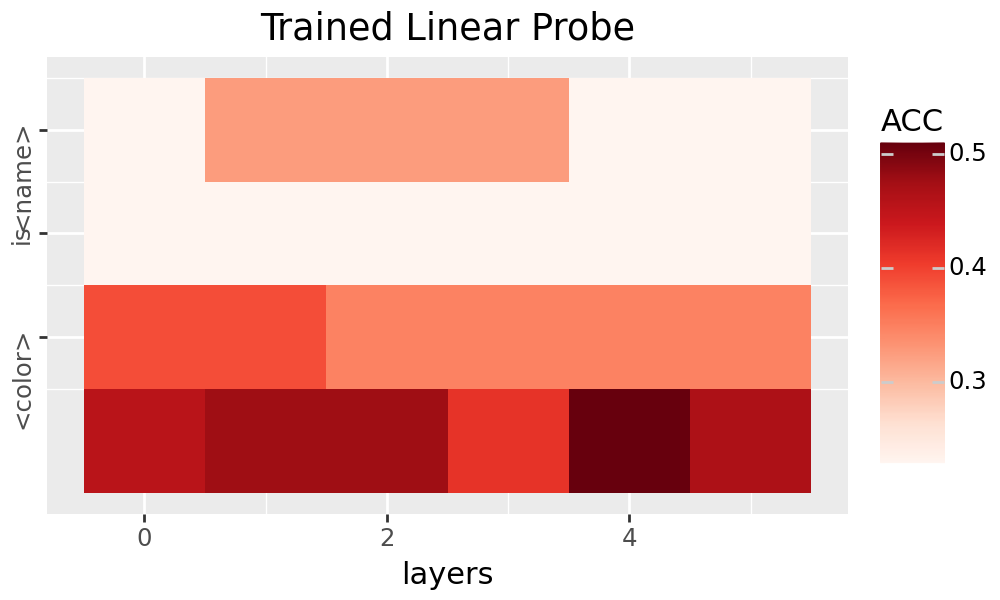

In [22]:
df["layer"] = df["layer"].astype(int)
df["pos"] = df["position"].astype(int)
df["ACC"] = df["acc"].astype(float)

custom_labels = ["<name>", "is", "<color>"]
breaks = [0, 1, 2]

plot = (
    ggplot(df, aes(x="layer", y="pos", fill="ACC"))
    + geom_tile()
    + scale_fill_cmap("Reds") + xlab("layers")
    + scale_y_reverse(
        limits = (-0.5, 3.5),
        breaks=breaks, labels=custom_labels)
    + theme(figure_size=(5, 3)) + ylab("")
    + theme(axis_text_y  = element_text(angle = 90, hjust = 1))
    + ggtitle("Trained Linear Probe")
)

display(plot)